In [2]:
import numpy as np
import xarray as xr

import datetime as dt
import os
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
import re
from scipy.signal import welch, csd
from scipy.stats import chi2
from process_fast_data.fast_data_calculate_spectra_nomrd import calculate_mrd_for_df, fast_data_files_to_dataframe
from sublimpy import extrautils

In [3]:
# DATA_DIR = "/storage/elilouis/sublimationofsnow/"
DATA_DIR = "/Users/elischwat/Development/data/sublimationofsnow/"

DATES = pd.Series(['20230418', '20230419'])
DATE_LOCAL = '20230418'

# DATES = pd.Series(['20230409', '20230410'])
# DATE_LOCAL = '20230409'

# TOOLS

## SAIL Data

In [4]:
class FastData(object):
    data = None

class FastDataSAIL(FastData):
    @staticmethod
    def open_raw(files):
        files = sorted(files)
        high_rate_dfs = []
        for file in files:
            # Regular expression. extract date
            date = re.search(r"gucecorM1\.00\.(\d+)\.", file).group(1)
            df = pd.read_csv(file, skiprows=1, header=None).rename(
                    columns = dict(
                        zip(range(0,10), 
                        [
                            'Timestamp',
                            'u',
                            'v',
                            'w',
                            'windspeed units (M = m/s)',
                            'Speed of Sound',
                            'Status (00 means okay)',
                            'CO2 analog voltage output',
                            'H20 analog voltage output',
                            'Checksum',
                        ])
                    )
                )
            df['time'] = pd.to_datetime(
                f'{date} ' + df['Timestamp'].str[:-3],
                format="%Y%m%d %H:%M:%S.%f"
            )
            high_rate_dfs.append(df)
        return pd.concat(high_rate_dfs).set_index('time')
    
    @staticmethod
    def double_rotation(df, u_col, v_col, w_col):
        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

        # SECOND ROTATION
        mean_u = df[u_col].mean()
        mean_w = df[w_col].mean()
        phi = np.arctan2(mean_w, mean_u)
        adj_u = df[u_col]*np.cos(phi) + df[w_col]*np.sin(phi)
        adj_w = - df[u_col]*np.sin(phi) + df[w_col]*np.cos(phi)
        df[u_col] = adj_u
        df[w_col] = adj_w
        print(
            'Means after 2nd rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )
        return df
    
    def apply_direction_rotation(df, u_col, v_col, w_col, bearing):
        # + Ugeo represents wind blowing to the East (confusingly known as a "westerly"). 
        # + Vgeo is wind to the North (a "southerly" ). This is right handed with respect to an upward +Wgeo.


        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

# SAIL EC data

Open and wrangle the raw SAIL EC data

In [55]:
fast_data_files = DATES.apply(
    lambda date: glob.glob(
            os.path.join(
                DATA_DIR, 
                f"sail_fast_ecor_data/gucecorM1.00.{date}.000000.raw/**_sonic.raw"
            )
        )
).explode()
fast_data_files

0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
                           ...                        
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
Length: 96, dtype: object

In [56]:
fast_df_sail = FastDataSAIL.open_raw(fast_data_files)
fast_df_sail = utils.modify_df_timezone(fast_df_sail.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_sail = fast_df_sail.loc[DATE_LOCAL]
fast_df_sail = fast_df_sail.sort_index()

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

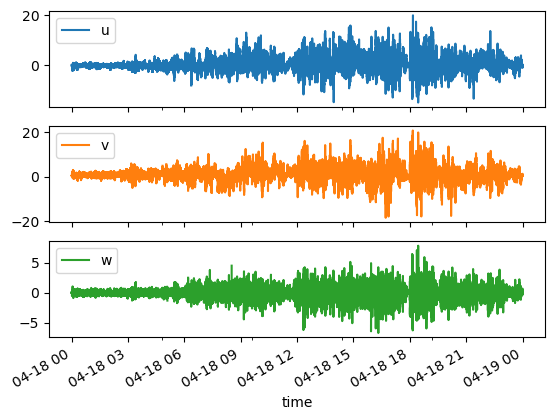

In [57]:
fast_df_sail[['u','v','w']].plot(subplots=True)

Calculate 30-minute mean u, v, w, and 30-min wind direction, plot it

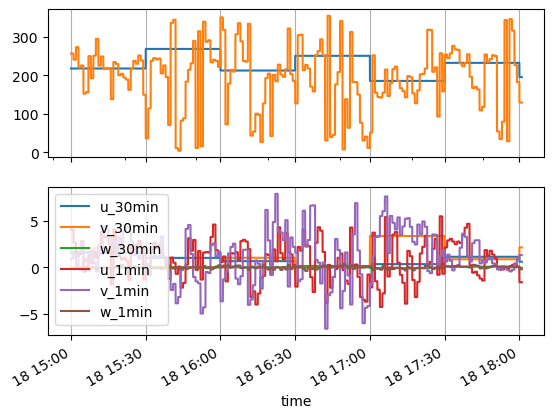

In [58]:
fast_df_sail = fast_df_sail.join(
    fast_df_sail.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sail = fast_df_sail.join(
    fast_df_sail.groupby(pd.Grouper(freq='1min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_1min',
        'v': 'v_1min',
        'w': 'w_1min',
    })
)
fast_df_sail['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sail['u_30min'], -fast_df_sail['v_30min']))
fast_df_sail['dir_30min'] = fast_df_sail['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

fast_df_sail['dir_1min'] = np.rad2deg(np.arctan2(-fast_df_sail['u_1min'], -fast_df_sail['v_1min']))
fast_df_sail['dir_1min'] = fast_df_sail['dir_1min'].apply(lambda dir: dir if dir >= 0 else dir+360)

fig, axes = plt.subplots(2,1)
fast_df_sail['dir_30min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_sail['dir_1min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_sail[['u_30min','v_30min','w_30min']].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[1])
fast_df_sail[['u_1min','v_1min','w_1min']].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [59]:
fast_df_sail = fast_df_sail.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 0.6618016000970252 1.1533358748732916e-16 0.04622414519004238
Means after 2nd rotation: 0.6634139201807067 1.1533358748732916e-16 -1.7559411395180424e-17
Means after 1st rotation: 0.9078757601427564 6.947449507584782e-17 0.07116325466865576
Means after 2nd rotation: 0.9106605320698945 6.947449507584782e-17 -5.746971100024176e-18
Means after 1st rotation: 0.35064010057550277 -6.000255329161135e-18 0.05577285762037964
Means after 2nd rotation: 0.35504801334290265 -6.000255329161135e-18 1.9157065191540498e-17
Means after 1st rotation: 2.278287499191075 1.6516584890547308e-16 -0.0662818459491865
Means after 2nd rotation: 2.279251458719014 1.6516584890547308e-16 -9.949749934064644e-18
Means after 1st rotation: 1.6761005345894482 -2.3911837285671085e-17 -0.046084167353162855
Means after 2nd rotation: 1.6767339540104949 -2.3911837285671085e-17 9.963265535696286e-19
Means after 1st rotation: 1.4498843014421823 1.3490925910749524e-16 -0.027700846955491278
Means after 2

In [60]:
fast_df_sail.index = fast_df_sail.index.get_level_values(1)

In [61]:
fast_df_sail['u'] = fast_df_sail['u'].interpolate()
fast_df_sail['v'] = fast_df_sail['v'].interpolate()
fast_df_sail['w'] = fast_df_sail['w'].interpolate()

Calculate MRD

In [62]:
mrd_uw_sail = fast_df_sail.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Timestep of fast data is: 100.0 ms
Dataset of length 114988, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 18017.41it/s]


Timestep of fast data is: 90.0 ms
Dataset of length 121765, with M = 16, permits 28 iterations.


100%|██████████| 28/28 [00:00<00:00, 27078.74it/s]


Timestep of fast data is: 100.0 ms
Dataset of length 115030, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 16044.52it/s]


Timestep of fast data is: 100.0 ms
Dataset of length 114261, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 20016.56it/s]


Timestep of fast data is: 100.0 ms
Dataset of length 114106, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 19765.03it/s]


Timestep of fast data is: 100.0 ms
Dataset of length 114764, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 18840.22it/s]


Timestep of fast data is: 70.0 ms
Dataset of length 113897, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 21718.08it/s]


Timestep of fast data is: 100.0 ms
Dataset of length 114148, with M = 16, permits 24 iterations.


100%|██████████| 24/24 [00:00<00:00, 16611.10it/s]


In [63]:
mrd_uw_sail.hour_group = mrd_uw_sail.hour_group.str.replace('2023-04-18 ', '')

In [64]:
daily_mrd_sail_chart = alt.Chart(
    mrd_uw_sail.reset_index().query("tau > 0")
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='sail')
daily_mrd_sail_chart

alt.Chart(...)

In [65]:
mrd_uw_sail['time range'] = mrd_uw_sail.start_time.astype(str) + ' - ' + mrd_uw_sail.end_time.astype(str)

In [66]:
alt.Chart(mrd_uw_sail.reset_index().query("tau > 0")).mark_line(strokeWidth=1).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Color('hour_group:O').scale(scheme='rainbow'),
    detail = 'time range'
).properties(width=300, height=300)

alt.Chart(...)

# SPLASH EC data

In [67]:
splash_files = np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "asfs/ASFS-50_Level2_SPLASH2021-2023/sledwind10hz.asfs50.level2.0.*.nc")
    ) if d in f]
    for d in DATES
]).flatten()
fast_df_splash = xr.open_mfdataset(splash_files).to_dataframe().rename(columns={
    'metek_u': 'u',
    'metek_v': 'v',
    'metek_w': 'w',
})

In [68]:
fast_df_splash = utils.modify_df_timezone(fast_df_splash.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_splash = fast_df_splash.loc[DATE_LOCAL]

In [69]:
fast_df_splash = fast_df_splash.join(
    fast_df_splash.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_splash['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_splash['u_30min'], -fast_df_splash['v_30min']))
fast_df_splash['dir_30min'] = fast_df_splash['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

fast_df_splash = fast_df_splash.join(
    fast_df_splash.groupby(pd.Grouper(freq='1min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_1min',
        'v': 'v_1min',
        'w': 'w_1min',
    })
)
fast_df_splash['dir_1min'] = np.rad2deg(np.arctan2(-fast_df_splash['u_1min'], -fast_df_splash['v_1min']))
fast_df_splash['dir_1min'] = fast_df_splash['dir_1min'].apply(lambda dir: dir if dir >= 0 else dir+360)

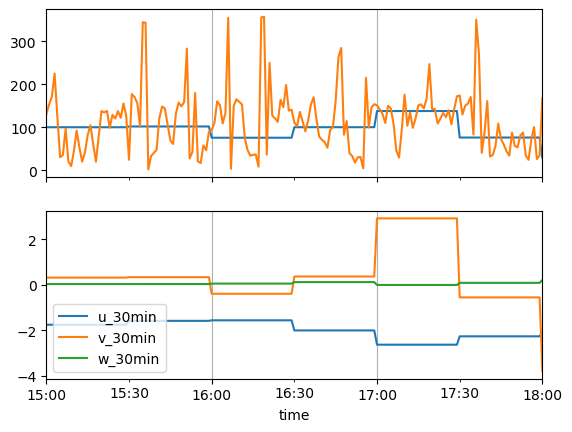

In [70]:
fast_df_splash_30min = fast_df_splash.groupby(pd.Grouper(freq='1min')).mean()
fig, axes = plt.subplots(2,1)
fast_df_splash_30min['dir_30min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_splash_30min['dir_1min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_splash_30min[['u_30min','v_30min','w_30min']].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [71]:
fast_df_splash = fast_df_splash.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 1.2666482748900492 -1.098831888759114e-16 0.0772666142960887
Means after 2nd rotation: 1.2690027509689321 -1.098831888759114e-16 4.226276495227362e-18
Means after 1st rotation: 1.0324662924246089 -1.266705712775666e-17 0.11195183171403797
Means after 2nd rotation: 1.0385181065427538 -1.266705712775666e-17 -4.486249399413817e-18
Means after 1st rotation: 1.428171009464732 2.957019466981188e-17 0.09460395440404679
Means after 2nd rotation: 1.431300925893781 2.957019466981188e-17 -3.3530488598804544e-17
Means after 1st rotation: 3.0867025680330658 -3.801882171832956e-16 -0.03322424124510729
Means after 2nd rotation: 3.0868813702033053 -3.801882171832956e-16 -5.5444115005897276e-18
Means after 1st rotation: 2.0051384174349507 -1.689725409703536e-16 0.04083325582150301
Means after 2nd rotation: 2.0055541448324257 -1.689725409703536e-16 2.125357741892729e-17
Means after 1st rotation: 2.0319159538937637 -1.6052391392183592e-16 0.05477563106018458
Means after 2nd rota

In [72]:
fast_df_splash.index = fast_df_splash.index.get_level_values(1)

In [73]:
fast_df_splash['u'] = fast_df_splash['u'].interpolate()
fast_df_splash['v'] = fast_df_splash['v'].interpolate()
fast_df_splash['w'] = fast_df_splash['w'].interpolate()

Calculate MRD

In [74]:
mrd_uw_splash = fast_df_splash.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 7386.20it/s]


Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 13527.93it/s]


Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 8033.60it/s]


Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 19547.36it/s]


Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 13158.11it/s]


Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 26578.27it/s]


Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 23488.10it/s]


Timestep of fast data is: 100.0 ms
Dataset of length 108000, with M = 16, permits 21 iterations.


100%|██████████| 21/21 [00:00<00:00, 23863.56it/s]


In [75]:
mrd_uw_splash.hour_group = mrd_uw_splash.hour_group.str.replace('2023-04-18 ', '')

In [76]:
alt.Chart(mrd_uw_splash.reset_index()).mark_boxplot(size=10, outliers=False).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Column('hour_group'),
).properties(width=200, height=200)

alt.Chart(...)

In [77]:
mrd_uw_splash.hour_group.unique()

array(['00:00:00 - 02:59:59.900000', '03:00:00 - 05:59:59.900000',
       '06:00:00 - 08:59:59.900000', '09:00:00 - 11:59:59.900000',
       '12:00:00 - 14:59:59.900000', '15:00:00 - 17:59:59.900000',
       '18:00:00 - 20:59:59.900000', '21:00:00 - 23:59:59.900000'],
      dtype=object)

In [78]:
daily_mrd_splash_chart = alt.Chart(
    mrd_uw_splash.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='splash')
daily_mrd_splash_chart

alt.Chart(...)

# SOS EC data

Open data, average from 20hz to 10hz

In [5]:
sos_file_list = sorted(np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_**.nc")
    ) if d in f]
    for d in DATES
]).flatten())

In [6]:

fast_df_sos_all_data = fast_data_files_to_dataframe(
    sos_file_list,
    rotation='none'
)

In [7]:
fast_df_sos_all_data = utils.modify_df_timezone(fast_df_sos_all_data, 'UTC', 'US/Mountain')
fast_df_sos_all_data = fast_df_sos_all_data.set_index('time').loc[DATE_LOCAL]

In [8]:
fast_df_sos = fast_df_sos_all_data[['u_3m_c', 'v_3m_c', 'w_3m_c']].rename(columns={
    'u_3m_c': 'u',
    'v_3m_c': 'v',
    'w_3m_c': 'w',
})

In [9]:
fast_df_sos['dir'] = np.rad2deg(np.arctan2(-fast_df_sos['u'], -fast_df_sos['v']))

# Create 30min avgs
fast_df_sos = fast_df_sos.join(
    fast_df_sos.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sos['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sos['u_30min'], -fast_df_sos['v_30min']))
fast_df_sos['dir_30min'] = fast_df_sos['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

# Create 1min avgs
fast_df_sos = fast_df_sos.join(
    fast_df_sos.groupby(pd.Grouper(freq='1min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_1min',
        'v': 'v_1min',
        'w': 'w_1min',
    })
)
fast_df_sos['dir_1min'] = np.rad2deg(np.arctan2(-fast_df_sos['u_1min'], -fast_df_sos['v_1min']))
fast_df_sos['dir_1min'] = fast_df_sos['dir_1min'].apply(lambda dir: dir if dir >= 0 else dir+360)

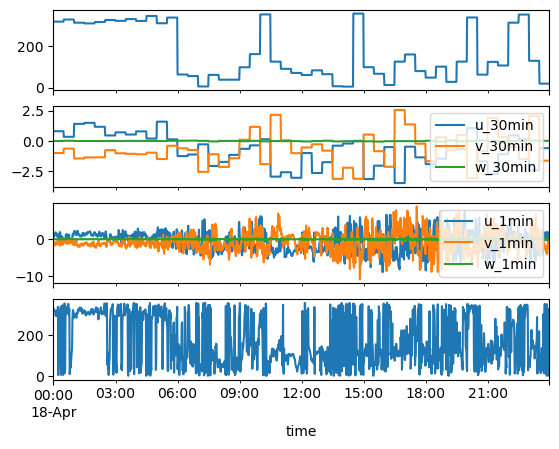

In [10]:
fast_df_sos_1min = fast_df_sos.groupby(pd.Grouper(freq='1min')).mean()
fig, axes = plt.subplots(4,1)
fast_df_sos_1min['dir_30min'].plot(ax=axes[0], sharex=True)
fast_df_sos_1min[['u_30min','v_30min','w_30min']].plot(ax=axes[1])
fast_df_sos_1min[['u_1min','v_1min','w_1min']].plot(ax=axes[2])
fast_df_sos_1min['dir_1min'].plot(ax=axes[3], sharex=True)
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply rotation into a given wind direction

In [11]:
# import numpy as np

# def project_winds(u, v):
#     # Convert -45 degrees to radians
#     angle = np.radians(-45)
#     print(angle)
#     # Define the rotation matrix
#     rotation_matrix = np.array([
#         [np.cos(angle), -np.sin(angle)],
#         [np.sin(angle), np.cos(angle)]
#     ])
#     print(rotation_matrix)
#     # Original wind vector
#     wind_vector = np.array([u, v])
#     print(wind_vector)
#     # Projected wind vector
#     projected_vector = rotation_matrix @ wind_vector
#     print(projected_vector)
#     return projected_vector

# # Example usage
# u = 10  # Westerly wind component
# v = 5   # Southerly wind component
# projected = project_winds(u, v)
# print("Projected winds:", projected)

In [12]:
# src = fast_df_sos.loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1501']
# u, v = project_winds(
#     src['u'],
#     src['v']
# )
# src['u_proj'] = u 
# src['v_proj'] = v
# src['dir_proj'] = np.rad2deg(np.arctan2(-src['u_proj'], -src['v_proj']))

In [13]:
# src[['u', 'v', 'dir']].plot(subplots=True)

In [14]:
# src[['u_proj', 'v_proj', 'dir_proj']].plot(subplots=True)

Apply double rotation to 3hr chunks

In [15]:
fast_df_sos = fast_df_sos.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 1.4472486 -3.051758e-08 0.0074909516
Means after 2nd rotation: 1.4472678 -3.051758e-08 1.165602e-09
Means after 1st rotation: 1.2023139 2.8257016e-08 0.008348804
Means after 2nd rotation: 1.202343 2.8257016e-08 1.2009232e-09
Means after 1st rotation: 1.9015547 -2.2605613e-08 0.011437975
Means after 2nd rotation: 1.9015889 -2.2605613e-08 -9.889956e-10
Means after 1st rotation: 1.5724633 1.3111256e-07 -0.0052673933
Means after 2nd rotation: 1.5724721 1.3111256e-07 -1.2892264e-09
Means after 1st rotation: 1.9473157 -8.251049e-08 -0.011317748
Means after 2nd rotation: 1.9473485 -8.251049e-08 5.651403e-10
Means after 1st rotation: 1.8408698 -9.94647e-08 -0.018046634
Means after 2nd rotation: 1.8409578 -9.94647e-08 -4.803693e-09
Means after 1st rotation: 1.2515265 -1.808449e-07 0.009646556
Means after 2nd rotation: 1.2515633 -1.808449e-07 1.9515003e-09
Means after 1st rotation: 1.0377959 9.042245e-08 0.00890773
Means after 2nd rotation: 1.037834 9.042245e-08 1.62477

In [16]:
fast_df_sos.index = fast_df_sos.index.get_level_values(1)

In [17]:
fast_df_sos['u'] = fast_df_sos['u'].interpolate()
fast_df_sos['v'] = fast_df_sos['v'].interpolate()
fast_df_sos['w'] = fast_df_sos['w'].interpolate()

Calculate TKE

In [18]:
fast_df_sos['tke'] = 0.5 * ( fast_df_sos['u']**2 + fast_df_sos['v']**2 + fast_df_sos['w']**2 ) 

Calculate MRD

In [19]:
mrd_uu_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'u', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)
mrd_vv_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'v', 'v', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)
mrd_ww_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'w', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

mrd_wtke_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w', 'tke']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'w', 'tke', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:09<00:00,  4.31it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.74it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.86it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.80it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.90it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.86it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.84it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.96it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.85it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.83it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.88it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.79it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.85it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.89it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.89it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.76it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.31it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:08<00:00,  4.96it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.58it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.80it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.82it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.92it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.67it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.76it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.97it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.49it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.78it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.74it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.66it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.85it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.99it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 216000, with M = 17, permits 42 iterations.


100%|██████████| 42/42 [00:07<00:00,  5.76it/s]


In [20]:
mrd_wtke_sos = calculate_mrd_for_df(fast_df_sos.reset_index(), 'w', 'tke', M=15, shift=1200, parallelism=20)

Got data of length 1728000. using M = 15
Timestep of fast data is: 50.0 ms
Dataset of length 1728000, with M = 15, permits 1412 iterations.


100%|██████████| 1412/1412 [05:34<00:00,  4.22it/s]


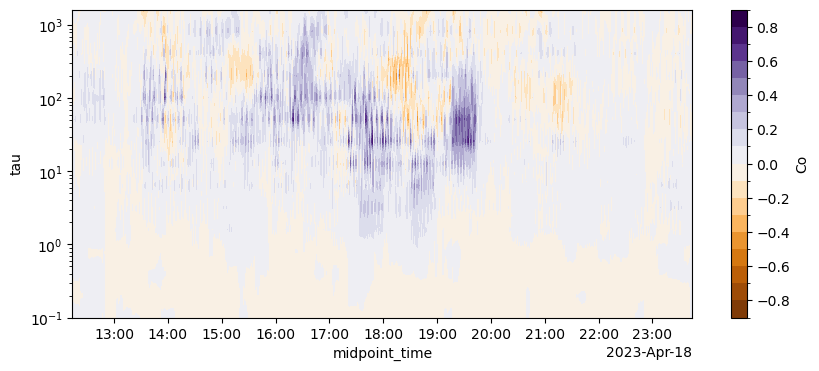

In [21]:
src = mrd_wtke_sos.copy()
src['midpoint_time'] = src['start_time'] + (src['end_time'] - src['start_time']) / 2
src = src[src.start_time.dt.hour >= 12]
src = src.reset_index()
ds = src.set_index(['midpoint_time', 'tau']).to_xarray()
ds['Co'].plot.contourf(x='midpoint_time', y='tau', cmap='PuOr', levels=20, figsize=(10,4))
plt.yscale('log')

In [22]:
alt.Chart(
    mrd_uu_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='3m uu') | alt.Chart(
    mrd_vv_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='3m vv') | alt.Chart(
    mrd_ww_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='3m ww')

alt.HConcatChart(...)

In [38]:
mrd_uw_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

Timestep of fast data is: 50.0 ms
Dataset of length 12000, with M = 13, permits 7 iterations.


100%|██████████| 7/7 [00:00<00:00, 6226.96it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 12000, with M = 13, permits 7 iterations.


100%|██████████| 7/7 [00:00<00:00, 4461.35it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 12000, with M = 13, permits 7 iterations.


100%|██████████| 7/7 [00:00<00:00, 9383.23it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 12000, with M = 13, permits 7 iterations.


100%|██████████| 7/7 [00:00<00:00, 11550.01it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 12000, with M = 13, permits 7 iterations.


100%|██████████| 7/7 [00:00<00:00, 5572.24it/s]


Timestep of fast data is: 50.0 ms
Dataset of length 12000, with M = 13, permits 7 iterations.


100%|██████████| 7/7 [00:00<00:00, 10215.77it/s]


In [39]:
mrd_uw_sos.hour_group = mrd_uw_sos.hour_group.str.replace('2023-04-09 ', '')

In [40]:
daily_mrd_sos_chart = alt.Chart(
    mrd_uw_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q').scale(domain = [-0.1, 0.05]),
    alt.Color('hour_group:O'),
).properties(width=200, height=200, title='sos')
daily_mrd_sos_chart

alt.Chart(...)

In [121]:
mrd_uw_sos['time_range'] = mrd_uw_sos.apply(
    lambda row: str(row['start_time'].time()) + ' - ' + str(row['end_time'].time()),
    axis=1
)

In [124]:
mrd_uw_sos.hour_group.unique()

array(['2023-04-18 00:00:00 - 2023-04-18 02:59:59.950000',
       '2023-04-18 03:00:00 - 2023-04-18 05:59:59.950000',
       '2023-04-18 06:00:00 - 2023-04-18 08:59:59.950000',
       '2023-04-18 09:00:00 - 2023-04-18 11:59:59.950000',
       '2023-04-18 12:00:00 - 2023-04-18 14:59:59.950000',
       '2023-04-18 15:00:00 - 2023-04-18 17:59:59.950000',
       '2023-04-18 18:00:00 - 2023-04-18 20:59:59.950000',
       '2023-04-18 21:00:00 - 2023-04-18 23:59:59.950000'], dtype=object)

In [130]:
src = mrd_uw_sos.query("""
        hour_group == '2023-04-18 15:00:00 - 2023-04-18 17:59:59.950000'
    """).reset_index()
alt.Chart(
    src.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Color('time_range:O').scale(scheme='purpleorange'),
).properties(width=500, height=500, title='sos')

alt.Chart(...)

In [123]:
src = mrd_uw_sos.query("""
        hour_group == '2023-04-18 18:00:00 - 2023-04-18 20:59:59.950000'
    """).reset_index()
alt.Chart(
    src.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Color('time_range:O').scale(scheme='purpleorange'),
).properties(width=500, height=500, title='sos')

alt.Chart(...)

# Plot three sites comparison plot

In [99]:
(
    daily_mrd_splash_chart & daily_mrd_sail_chart & daily_mrd_sos_chart
).resolve_scale(
    color='independent',
    x='shared',
    y='shared'
)

alt.VConcatChart(...)

# Calculate MRDs for April 18 1500-1800, at SOS, multiple heights

In [135]:
fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800']
# fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 1800': f'{DATE_LOCAL} 2100']
# fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 1200': f'{DATE_LOCAL} 1500']
# fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 0000': f'{DATE_LOCAL} 0300']

In [136]:
mrds_df_ls = []
for h in [3,5,10,15,20]:
    print(f"Processing height: {h}m")
    fast_df_sos_oneheight = fast_df_sos_1500_1800[[f'u_{h}m_c', f'v_{h}m_c', f'w_{h}m_c']].rename(columns={
        f'u_{h}m_c': 'u',
        f'v_{h}m_c': 'v',
        f'w_{h}m_c': 'w',
    })
    fast_df_sos_oneheight = FastDataSAIL.double_rotation(fast_df_sos_oneheight, 'u', 'v', 'w')
    fast_df_sos_oneheight['u'] = fast_df_sos_oneheight['u'].interpolate()
    fast_df_sos_oneheight['v'] = fast_df_sos_oneheight['v'].interpolate()
    fast_df_sos_oneheight['w'] = fast_df_sos_oneheight['w'].interpolate()
    mrds_df_ls.append(
        calculate_mrd_for_df(
            fast_df_sos_oneheight.reset_index(), 'u', 'w', shift=2000, parallelism=20
        ).assign(
            height = h
        )
    )

Processing height: 3m
Means after 1st rotation: 1.8745301 -1.3938046e-07 -0.018657666
Means after 2nd rotation: 1.8746231 -1.3938046e-07 -8.4302704e-10
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


  0%|          | 0/43 [00:00<?, ?it/s]

100%|██████████| 43/43 [00:12<00:00,  3.31it/s]


Processing height: 5m
Means after 1st rotation: 1.9812292 -1.3038817e-07 -0.047928836
Means after 2nd rotation: 1.9818088 -1.3038817e-07 -1.5455495e-08
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:07<00:00,  5.51it/s]


Processing height: 10m
Means after 1st rotation: 2.0202928 -2.2255914e-07 -0.11310487
Means after 2nd rotation: 2.023456 -2.2255914e-07 -1.124036e-09
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:07<00:00,  5.79it/s]


Processing height: 15m
Means after 1st rotation: 1.9361435 8.542674e-08 -0.15509997
Means after 2nd rotation: 1.9423461 8.542674e-08 1.0116325e-08
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:07<00:00,  5.68it/s]


Processing height: 20m
Means after 1st rotation: 1.9239379 -8.767481e-08 -0.22260587
Means after 2nd rotation: 1.9367732 -8.767481e-08 -2.2480721e-08
Timestep of fast data is: 50.0 ms
Dataset of length 217200, with M = 17, permits 43 iterations.


100%|██████████| 43/43 [00:07<00:00,  5.68it/s]


In [140]:
alt.Chart(
    pd.concat(mrds_df_ls).query("height > 2")
).mark_line(point=True).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Color('start_time:O'),
    alt.Row('height:O'),
    tooltip = 'height:O',
).properties(height=100)

alt.Chart(...)

## Rotate into pre-determined wind direction

In [ ]:
def double_rotation(df, u_col, v_col, w_col):
        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

        # SECOND ROTATION
        mean_u = df[u_col].mean()
        mean_w = df[w_col].mean()
        phi = np.arctan2(mean_w, mean_u)
        adj_u = df[u_col]*np.cos(phi) + df[w_col]*np.sin(phi)
        adj_w = - df[u_col]*np.sin(phi) + df[w_col]*np.cos(phi)
        df[u_col] = adj_u
        df[w_col] = adj_w
        print(
            'Means after 2nd rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )
        return df

In [ ]:
sos_file_list = sorted(np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_**.nc")
    ) if d in f]
    for d in DATES
]).flatten())

fast_df_sos_all_data = fast_data_files_to_dataframe(sos_file_list, rotation='none')
fast_df_sos_all_data = utils.modify_df_timezone(fast_df_sos_all_data, 'UTC', 'US/Mountain')
fast_df_sos_all_data = fast_df_sos_all_data.set_index('time').loc[DATE_LOCAL]
fast_df_sos = fast_df_sos_all_data[['u_3m_c', 'v_3m_c', 'w_3m_c']].rename(columns={
    'u_3m_c': 'u',
    'v_3m_c': 'v',
    'w_3m_c': 'w',
})

# Calculate integral length scales for all datasets

## For discreet periods

In [ ]:
def find_root(result, autocorr_col, time_col):
    # Assuming `data` is your DataFrame
    # Replace `data` with the actual DataFrame variable
    column_0 = result[autocorr_col]  # Extract column 0
    lag_s = result[time_col]     # Extract 'lag (s)' column

    # Find indices where column 0 changes sign
    sign_changes = np.where(np.diff(np.sign(column_0)))[0]

    if len(sign_changes) > 0:
        # Get the first root
        idx = sign_changes[0]
        print(f"The first root is at lag (s): {lag_s[idx]}")
        return idx
        # # Linear interpolation to find the root
        # x1, x2 = lag_s.iloc[idx], lag_s.iloc[idx + 1]
        # y1, y2 = column_0.iloc[idx], column_0.iloc[idx + 1]
        # root = x1 - y1 * (x2 - x1) / (y2 - y1)
        print(f"The first root is at lag (s): {root}")
    else:
        print("No root found in column 0.")

In [ ]:
for time_period in [
    ('20230418 0000', '20230418 0301'),
    ('20230418 0301', '20230418 0601'),
    ('20230418 0601', '20230418 0901'),
    ('20230418 0901', '20230418 1201'),
    ('20230418 1201', '20230418 1501'),
    ('20230418 1501', '20230418 1801'),
    ('20230418 1801', '20230418 2101'),
    ('20230418 2101', '20230418 2359'),
]:
    # SAIL
    src_sail = fast_df_sail.loc[time_period[0]: time_period[1]]
    src_sail = src_sail.assign(
        spd = np.sqrt(src_sail['u']**2 + src_sail['v']**2)
    )
    spd_corr_result_sail = np.correlate(
        src_sail['spd'] - src_sail['spd'].mean(), 
        src_sail['spd'] - src_sail['spd'].mean(), 
        mode='full'
    )
    result_sail = spd_corr_result_sail[spd_corr_result_sail.size // 2:]
    result_sail = pd.DataFrame({"R": result_sail / float(result_sail.max())})
    result_sail['lag (s)'] = result_sail.index/10

    first_root_sail = find_root(result_sail, 'R',  'lag (s)')
    integral_result_sail = np.trapz(
        result_sail['R'].loc[:first_root_sail],
        result_sail['lag (s)'].loc[:first_root_sail],
    )
    integral_length_scale_sail = (integral_result_sail * src_sail['spd'].mean())
    print(f'The integration result_sail is: {integral_result_sail}')
    print(f'The mean wind speed is: {src_sail['spd'].mean()}')
    print(f"The integral length scale is: {integral_length_scale_sail}")


    # SPLASH
    src_splash = fast_df_splash.loc[time_period[0]: time_period[1]]
    src_splash = src_splash.assign(
        spd = np.sqrt(src_splash['u']**2 + src_splash['v']**2)
    )
    spd_corr_result_splash = np.correlate(
        src_splash['spd'] - src_splash['spd'].mean(), 
        src_splash['spd'] - src_splash['spd'].mean(), 
        mode='full'
    )
    result_splash = spd_corr_result_splash[spd_corr_result_splash.size // 2:]
    result_splash = pd.DataFrame({"R": result_splash / float(result_splash.max())})
    result_splash['lag (s)'] = result_splash.index/10

    first_root_splash = find_root(result_splash, 'R',  'lag (s)')
    integral_result_splash = np.trapz(
        result_splash['R'].loc[:first_root_splash],
        result_splash['lag (s)'].loc[:first_root_splash],
    )
    integral_length_scale_splash = (integral_result_splash * src_splash['spd'].mean())
    print(f'The integration result_splash is: {integral_result_splash}')
    print(f'The mean wind speed is: {src_splash['spd'].mean()}')
    print(f"The integral length scale is: {integral_length_scale_splash}")


    # SOS
    src_sos = fast_df_sos.loc[time_period[0]: time_period[1]]
    src_sos = src_sos.assign(
        spd = np.sqrt(src_sos['u']**2 + src_sos['v']**2)
    )
    spd_corr_result_sos = np.correlate(
        src_sos['spd'] - src_sos['spd'].mean(), 
        src_sos['spd'] - src_sos['spd'].mean(), 
        mode='full'
    )
    result_sos = spd_corr_result_sos[spd_corr_result_sos.size // 2:]
    result_sos = pd.DataFrame({"R": result_sos / float(result_sos.max())})
    result_sos['lag (s)'] = result_sos.index/20

    first_root_sos = find_root(result_sos, 'R',  'lag (s)')
    integral_result_sos = np.trapz(
        result_sos['R'].loc[:first_root_sos],
        result_sos['lag (s)'].loc[:first_root_sos],
    )
    integral_length_scale_sos = integral_result_sos * src_sos['spd'].mean()
    print(f'The integration result_sos is: {integral_result_sos}')
    print(f'The mean wind speed is: {src_sos['spd'].mean()}')
    print(f"The integral length scale is: {integral_length_scale_sos}")

    plt.plot(result_sail['lag (s)'], result_sail["R"], label='Gothic (SAIL)')
    plt.plot(result_splash['lag (s)'], result_splash["R"], label='Avery Picnic (SPLASH)')
    plt.plot(result_sos['lag (s)'], result_sos["R"], label='Kettle Ponds (SOS)')
    plt.text(x=1800, y=1, s = f"Lsail = {round(integral_length_scale_sail,0)}")
    plt.text(x=1800, y=0.95, s = f"Lsplash = {round(integral_length_scale_splash,0)}")
    plt.text(x=1800, y=0.9, s = f"Lsos = {round(integral_length_scale_sos,0)}")
    plt.title(time_period)
    plt.axhline(0)
    plt.legend()
    plt.show()

## For entire day, using moving window averages

In [ ]:
src_sail_wholeday = fast_df_sail.assign(
    spd = np.sqrt(fast_df_sail['u']**2 + fast_df_sail['v']**2)
)
src_sail_wholeday['spd_fluc'] = src_sail_wholeday['spd'] - src_sail_wholeday['spd'].rolling(window='30min').mean()
spd_corr_result_sail_wholeday = np.correlate(
    src_sail_wholeday['spd_fluc'],
    src_sail_wholeday['spd_fluc'],
    mode='full'
)


In [ ]:
src_splash_wholeday = fast_df_splash.assign(
    spd = np.sqrt(fast_df_splash['u']**2 + fast_df_splash['v']**2)
)
src_splash_wholeday['spd_fluc'] = src_splash_wholeday['spd'] - src_splash_wholeday['spd'].rolling(window='30min').mean()
spd_corr_result_splash_wholeday = np.correlate(
    src_splash_wholeday['spd_fluc'],
    src_splash_wholeday['spd_fluc'],
    mode='full'
)


In [ ]:
src_sos_wholeday = fast_df_sos.assign(
    spd = np.sqrt(fast_df_sos['u']**2 + fast_df_sos['v']**2)
)
src_sos_wholeday['spd_fluc'] = src_sos_wholeday['spd'] - src_sos_wholeday['spd'].rolling(window='30min').mean()
spd_corr_result_sos_wholeday = np.correlate(
    src_sos_wholeday['spd_fluc'],
    src_sos_wholeday['spd_fluc'],
    mode='full'
)


In [ ]:
result_sail = spd_corr_result_sail_wholeday[spd_corr_result_sail_wholeday.size // 2:]
result_sail = pd.DataFrame({"R": result_sail / float(result_sail.max())})
result_sail['lag_s'] = result_sail.index/10
first_root_sail = find_root(result_sail, 'R',  'lag_s')
integral_result_sail = np.trapz(
    result_sail['R'].loc[:first_root_sail],
    result_sail['lag_s'].loc[:first_root_sail],
)
integral_length_scale_sail = (integral_result_sail * src_sail['spd'].mean())


result_splash = spd_corr_result_splash_wholeday[spd_corr_result_splash_wholeday.size // 2:]
result_splash = pd.DataFrame({"R": result_splash / float(result_splash.max())})
result_splash['lag_s'] = result_splash.index/10
first_root_splash = find_root(result_splash, 'R',  'lag_s')
integral_result_splash = np.trapz(
    result_splash['R'].loc[:first_root_splash],
    result_splash['lag_s'].loc[:first_root_splash],
)
integral_length_scale_splash = (integral_result_splash * src_splash['spd'].mean())


result_sos = spd_corr_result_sos_wholeday[spd_corr_result_sos_wholeday.size // 2:]
result_sos = pd.DataFrame({"R": result_sos / float(result_sos.max())})
result_sos['lag_s'] = result_sos.index/20
first_root_sos = find_root(result_sos, 'R',  'lag_s')
integral_result_sos = np.trapz(
    result_sos['R'].loc[:first_root_sos],
    result_sos['lag_s'].loc[:first_root_sos],
)
integral_length_scale_sos = (integral_result_sos * src_sos['spd'].mean())

In [ ]:
alt.Chart(result_sail.query("lag_s < 5000")).transform_filter(
    alt.datum.lag_s > 0
).mark_line().encode(
    alt.X('lag_s:Q').scale(type='log'),
    alt.Y('R:Q')
).properties(title=f'L = {round(integral_length_scale_sail, 1)}') | alt.Chart(result_splash.query("lag_s < 5000")).transform_filter(
    alt.datum.lag_s > 0
).mark_line().encode(
    alt.X('lag_s:Q').scale(type='log'),
    alt.Y('R:Q')
).properties(title=f'L = {round(integral_length_scale_splash, 1)}') | alt.Chart(result_sos.query("lag_s < 5000")).transform_filter(
    alt.datum.lag_s > 0
).mark_line().encode(
    alt.X('lag_s:Q').scale(type='log'),
    alt.Y('R:Q')
).properties(title=f'L = {round(integral_length_scale_sos, 1)}')